In [12]:
import os
os.chdir("c:\\Users\\zhaobang\\OneDrive\\桌面\\NewKerosene")
from sktime.datasets import load_italy_power_demand
import pandas as pd
from sktime.distances import dtw_distance
import numpy as np
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
from modules.kerosenePreprocess import Kerosene
from modules import DataDrop as DD
from tqdm import tqdm,trange



In [13]:
kerosene = Kerosene("./raw_data/2-supply-histories-with-sensor.csv")
# some special id to drop. Apporo dont need this
kerosene.normal_use.set_index("customer_id", inplace=True)
kerosene.normal_use.drop([666, 663, 650, 1086], inplace=True)
kerosene.normal_use.reset_index(inplace=True)
for i in range(kerosene.normal_use.shape[0]):
    if kerosene.normal_use.loc[i, "volume"] == 0:
        kerosene.normal_use.drop(i, inplace=True)
kerosene.normal_use.reset_index(inplace=True)

normal_use_drop = DD.supply_data_drop(kerosene.normal_use.copy())

clustering_data = normal_use_drop.copy()

c:\Users\zhaobang\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [14]:

clustering_data.pop("tank_type_id")
clustering_data.pop("purpose")
date_time = clustering_data.pop("supplied_at")
"""
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

clustering_data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
clustering_data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
"""

"\ntimestamp_s = date_time.map(pd.Timestamp.timestamp)\nday = 24*60*60\nyear = (365.2425)*day\n\nclustering_data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))\nclustering_data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))\n"

In [15]:
clustering_data.head()

,customer_id,level_0,index,volume
0,637,55,430,302.7
1,637,56,431,226.2
2,637,57,432,187.3
3,637,58,433,273.5
4,637,59,434,222.0


In [16]:
clustering_data.pop("index")
clustering_data.pop("level_0")

0          55
1          56
2          57
3          58
4          59
        ...  
7207    13975
7208    13976
7209    13977
7210    13978
7211    13979
Name: level_0, Length: 7212, dtype: int64

In [17]:
df_id = clustering_data[clustering_data["customer_id"] == 639]

In [18]:
ALL_ID = pd.unique(clustering_data["customer_id"])

In [19]:
len(ALL_ID)

121

In [20]:
id_df = []

In [21]:
for id in ALL_ID:
    id_df.append(clustering_data[clustering_data["customer_id"] == id])

In [22]:
id_df[1]

,customer_id,volume
69,719,413.9
70,719,351.2
71,719,390.4
72,719,420.1
73,719,501.9
...,...,...
293,719,359.3
294,719,489.7
295,719,360.8
296,719,266.6


In [23]:
for i in id_df:
    i.pop("customer_id")

In [24]:
ar_data = []
for i in id_df:
    ar_data.append(i.to_numpy())

In [25]:
len(ar_data)

121

In [26]:
ar_data[1].shape

(229, 1)

In [27]:
type(ar_data[1])

numpy.ndarray

In [28]:
n_series = len(ar_data)
distance_matrix = np.zeros(shape=(n_series, n_series))

In [29]:
# Build distance matrix
for i in tqdm(range(n_series), desc='calculate distance matrix: '):
    for j in range(n_series):
        x = ar_data[i]
        y = ar_data[j]
        if i != j and distance_matrix[i, j] == 0:
            dist = dtw_distance(x, y)
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

calculate distance matrix: 100%|██████████| 121/121 [13:29<00:00,  6.69s/it]


c:\Users\zhaobang\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\cluster\hierarchy.py:364: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='complete', metric='euclidean')


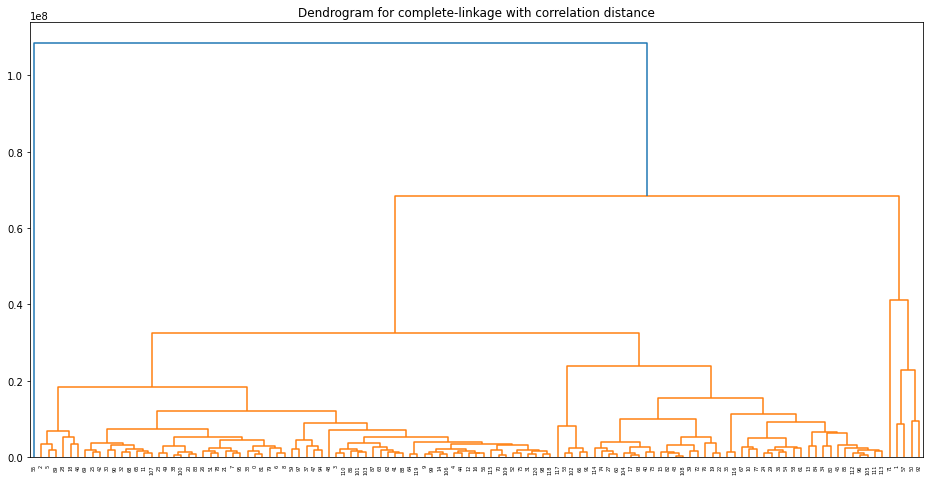

In [30]:
def hierarchical_clustering(dist_mat, method='complete'):
    if method == 'complete':
        Z = complete(distance_matrix)
    if method == 'single':
        Z = single(distance_matrix)
    if method == 'average':
        Z = average(distance_matrix)
    if method == 'ward':
        Z = ward(distance_matrix)
    
    fig = plt.figure(figsize=(16, 8))
    dn = dendrogram(Z)
    plt.title(f"Dendrogram for {method}-linkage with correlation distance")
    plt.show()
    
    return Z

linkage_matrix = hierarchical_clustering(distance_matrix)

In [31]:
from scipy.cluster.hierarchy import fcluster

# select maximum number of clusters
cluster_labels_2 = fcluster(linkage_matrix, 2, criterion='maxclust')
print(np.unique(cluster_labels_2))
#>> 4 unique clusters
cluster_labels_3 = fcluster(linkage_matrix, 3, criterion='maxclust')
print(np.unique(cluster_labels_3))
#>> 10 unique clusters
cluster_labels_4 = fcluster(linkage_matrix, 4, criterion='maxclust')
print(np.unique(cluster_labels_4))
cluster_labels_5 = fcluster(linkage_matrix, 5, criterion='maxclust')
print(np.unique(cluster_labels_5))

# hand-select an appropriate cut-off on the dendrogram
# cluster_labels_5 = fcluster(linkage_matrix, 2, criterion='distance')
# print(np.unique(cluster_labels_5))
#>> 3 unique clusters
# cluster_labels_6 = fcluster(linkage_matrix, 2, criterion='distance')
# print(np.unique(cluster_labels_6))
#>> 2 unique clusters

[1 2]
[1 2 3]
[1 2 3 4]
[1 2 3 4 5]


In [85]:
df_cluster = {"ID": ALL_ID, "Cluster": cluster_labels_4}

In [36]:
df = pd.DataFrame(data=df_cluster)

In [37]:
df.to_csv("./ClusterData/4_clusters.csv", index=False)

In [38]:
df_cluster = {"ID": ALL_ID, "Cluster": cluster_labels_3}
df = pd.DataFrame(data=df_cluster)
df.to_csv("./ClusterData/3_clusters.csv", index=False)

In [39]:
df_cluster = {"ID": ALL_ID, "Cluster": cluster_labels_5}
df = pd.DataFrame(data=df_cluster)
df.to_csv("./ClusterData/5_clusters.csv", index=False)

In [40]:
cluster_labels_6 = fcluster(linkage_matrix, 6, criterion='maxclust')
df_cluster = {"ID": ALL_ID, "Cluster": cluster_labels_6}
df = pd.DataFrame(data=df_cluster)
df.to_csv("./ClusterData/6_clusters.csv", index=False)

In [ ]:
for i in range()